# Gradient based learning with logistic regression

Author: Alexandre Gramfort

### Let's first do it by end

In [1]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

# Make it binary
X = X[y < 2]
y = y[y < 2]

y[y == 0] = -1

In [3]:
X.shape, y.shape, np.unique(y)

((100, 2), (100,), array([-1,  1]))

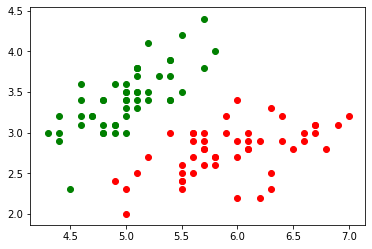

In [4]:
plt.scatter(X[y > 0, 0], X[y > 0, 1], color='r')
plt.scatter(X[y < 0, 0], X[y < 0, 1], color='g')

In [5]:
lambd = .01

def f(theta):
    """Logistic regression objective function"""
    w, b = theta[:-1], theta[-1]
    pobj = np.mean(np.log(1. + np.exp(- y * (np.dot(X, w) + b)))) + lambd * np.sum(w ** 2)
    return pobj

def fprime(theta):
    """Gradient of the logistic regression objective function"""
    w, b = theta[:-1], theta[-1]
    n = X.shape[0]
    ywTx = y * (np.dot(X, w) + b)
    temp = 1. / (1. + np.exp(ywTx))
    grad = np.zeros_like(theta)
    grad[:-1] = -np.dot(X.T, (y * temp)) / n + 2. * lambd * w
    grad[-1] = -np.sum(y * temp) / n
    return grad

Check your gradient:

In [6]:
from scipy.optimize import check_grad
check_grad(f, fprime, np.random.randn(3))

4.453183422345662e-08

### Let's learn by gradient descent

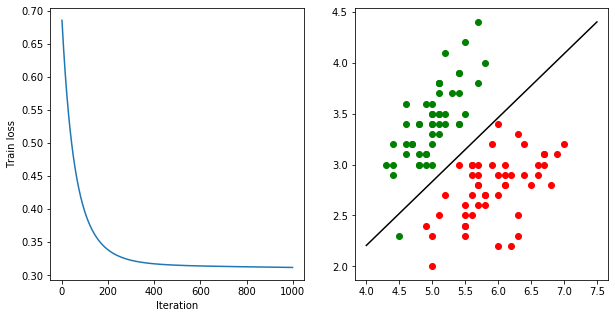

In [7]:
n_features = X.shape[1]
theta = np.zeros(n_features + 1)
step_size = 1e-1
n_iter = 1000
all_pobj = []

for k in range(n_iter):
    theta -= step_size * fprime(theta)
    all_pobj.append(f(theta))

w, b = theta[:-1], theta[-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(all_pobj)
ax1.set(xlabel='Iteration', ylabel='Train loss')

ax2.scatter(X[y > 0, 0], X[y > 0, 1], color='r')
ax2.scatter(X[y < 0, 0], X[y < 0, 1], color='g')
xx = np.linspace(4, 7.5, 10)
ax2.plot(xx,  (-b - w[0] * xx) / w[1], 'k')

### Let's learn by another descent algorithm (L-BFGS)

To learn more on quasi-Newton methods:

    J. Nocedal and S. J. Wright. Numerical optimization. Springer Series in Operations Research and Financial Engineering. Springer, New York, second edition, 2006.

In [8]:
from scipy.optimize import fmin_l_bfgs_b
fmin_l_bfgs_b?

In [9]:
alpha = 0.01
n_features = X.shape[1]
theta, _, _ = fmin_l_bfgs_b(f, np.zeros(n_features + 1), fprime)
w, b = theta[:-1], theta[-1]

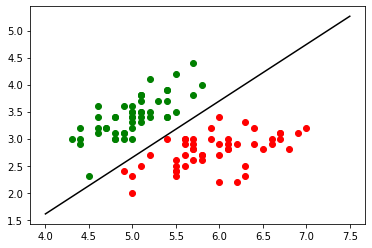

In [10]:
plt.scatter(X[y > 0, 0], X[y > 0, 1], color='r')
plt.scatter(X[y < 0, 0], X[y < 0, 1], color='g')
xx = np.linspace(4, 7.5, 10)
plt.plot(xx,  (-b - w[0] * xx) / w[1], 'k')

### Let's be lazy and avoid computing gradients

We'll be using PyTorch

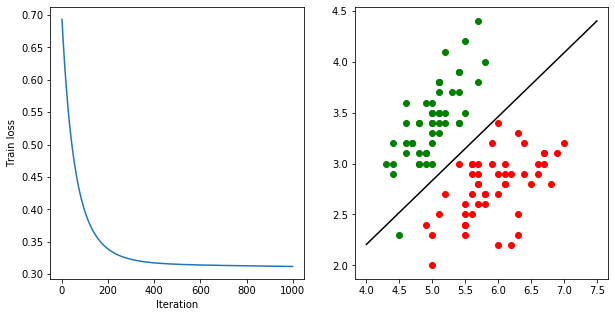

In [12]:
import matplotlib.pyplot as plt
import torch
from torch import nn

dtype = torch.float
device = torch.device("cpu")

X = torch.Tensor(X).to(device, dtype=dtype)
y = torch.Tensor(y).to(device, dtype=dtype)

n_features = X.shape[1]
w = torch.zeros(n_features, 1, device=device, dtype=dtype, requires_grad=True)
b = torch.zeros(1, 1, device=device, dtype=dtype, requires_grad=True)

losses = []
step_size = 1e-1

for t in range(1000):
    # Forward pass: compute predicted y using operations on Tensors
    y_pred = X @ w + b

    # Compute and print loss using operations on Tensors.
    loss = torch.log(1. + torch.exp(-y * y_pred[:, 0])).mean() + lambd * (w ** 2).sum()
    losses.append(loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w.grad and b.grad will be Tensors holding the gradient
    # of the loss with respect to w and b respectively.
    loss.backward()

    # Manually update weights and bias using gradient descent.
    # Wrap in torch.no_grad() because weights have requires_grad=True,
    # but we don't need to track this in autograd.
    with torch.no_grad():
        w -= step_size * w.grad
        b -= step_size * b.grad

        # Manually zero the gradients after updating weights
        w.grad.zero_()
        b.grad.zero_()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(losses)
ax1.set(xlabel='Iteration', ylabel='Train loss')

w = w.cpu().detach().numpy().ravel()
b = b.item()
ax2.scatter(X[y > 0, 0], X[y > 0, 1], color='r')
ax2.scatter(X[y < 0, 0], X[y < 0, 1], color='g')
xx = np.linspace(4, 7.5, 10)
ax2.plot(xx,  (-b - w[0] * xx) / w[1], 'k')